# Handout #5: Unsupervised Learning (optimization-based clustering)

## Problem 7

### Definition of the clustering function

We will develop two clustering functions. 
One for *crisp* and other for *fuzzy* clustering.

In [1]:
import numpy as np
import random


def proximity_sense():
    # if the proximity function is a 
    # - dissimilarity metric (DM), must return the minimum function
    # - simillarity metric (SM), must return the maximum function
    
    # we are working with a distance, 
    # so a dissimilarity metric must be assumed and 
    # return the min() function
    
    return min


def get_best_value(vector: np.ndarray) -> float:
    # returns the best value from 'vector'
    
    # will get the minimum or maximum value 
    # according to the DM or SM
    #
    sense_func = proximity_sense()
    best_value = sense_func(vector)
    
    return best_value


def get_best_index_from(vector: np.ndarray) -> int:
    # returns the position (zero indexed) of 
    # the minimum value or maximum value
    # that cotains 'vector' array
    
    if type(vector) != np.ndarray: 
        raise TypeError("'vector' must be a numpy array")
        
    best_position = np.where(vector == get_best_value(vector))[0][0]
    
    return best_position
    
    
def get_initial_thetas(X: np.ndarray, M: int) -> np.ndarray:
    # returns a random matrix of cluster definitions
    
    # test if we have sufficient datapoints
    #
    n_datapoints = len(X)
    
    if n_datapoints < M:
        raise ValueError("Insufficient number of datapoints")
    
    
    # as we can define the cluster by its radius, 
    # the matrix shape is M x 1
    # where M is the number of desired clusters
    #
    # to select the cluster's radius, 
    # will select M random datapoints and use 
    # its radius as the cluster one
    # 
    # we think its a very fast initialization method, 
    # but the drawback is that is not assured that
    # the M selected values have an uniform distribution
    # over the radius value space
    # we also verify that there aren't repeated values
    #
    radius_list = list()
    
    for j in range(M):
        rand_index = random.randint(a=0, b=n_datapoints - 1)
        radius = np.linalg.norm(X[rand_index])
        while radius in radius_list:
            rand_index = random.randint(a=0, b=n_datapoints - 1)
            radius = np.linalg.norm(X[rand_index])
        radius_list.append([radius])
    
    # sort list to try to get clusters ordered by their radius
    radius_list.sort()
    
    thetas = np.array(radius_list, dtype=float)
    
    return thetas


def proximity_func(datapoint: np.ndarray, theta: np.ndarray) -> float:
    # return the squared distance between 
    # 'datapoint' and cluster radius
    #
    # 'theta' is a ... say 'one dimension vector' 
    # containing cluster radius,
    # cause only the radius is needed to describe the cluster
    # due to it's centered at axes origin
    
    datapoint_norm = np.linalg.norm(datapoint)
    
    distance1 = datapoint_norm - theta[0]
    distance2 = distance1 * distance1 
    
    return distance2


def calc_membership_at(method: str, cluster_num: int, vector: np.ndarray) -> float:
    # return membership level of a datapoint to 'cluster_num'
    # according to the proximity values that 'vector' cotains

    if method == 'crisp':
        value = get_best_value(vector)
        if cluster_num == np.where(vector == value)[0][0]:
            level = 1.
        else:
            level = 0.
    elif method == 'fuzzy':
        level = 1.
        # TODO
    else:
        raise ValueError("only 'crisp' or 'fuzzy' clustering modes supported")
    
    return level


def calc_membership(method: str, func, X: np.ndarray, thetas: np.ndarray) -> np.ndarray:
    # return membership array
    #
    
    n_datapoints = len(X)
    n_clusters = len(thetas)
    
    membership = np.empty((n_datapoints, n_clusters), dtype=int)
    
    for i in range(n_datapoints):
        
        proximity_vector = np.empty(n_clusters, dtype=float)
        
        # populate proximity_vector
        #
        for j in range(n_clusters):
            proximity_vector[j] = proximity_func(X[i], thetas[j])
        
        # compute membership
        #
        for j in range(n_clusters):
            membership[i, j] = calc_membership_at(
                method=method,
                cluster_num=j, 
                vector=proximity_vector)
    
    return membership
    

def calc_cluster_radius(cluster_num: int, X: np.ndarray, U: np.ndarray) -> float:
    # return the (next) cluster radius
    #
    
    n_datapoints = len(X)
    
    momentum = 0.
    weight = 0.
        
    for i in range(n_datapoints):
            
        u_ij = U[i, cluster_num]
        x_i = X[i]
        x_i_norm = np.linalg.norm(x_i)
        momentum += u_ij * x_i_norm
        weight += u_ij
            
    radius = momentum / weight
    
    return radius


def calc_thetas(X: np.ndarray, M: int, U: np.ndarray) -> np.ndarray:
    # return new clusters definition array (thetas)
    # based on actual membership values
    
    n_datapoints = len(X)
    theta_list = list()
    
    for j in range(M):
        
        radius = calc_cluster_radius(
            cluster_num=j, X=X, U=U)

        theta_list.append([radius])
    
    thetas = np.array(theta_list, dtype=float)
                    
    return thetas


def calc_thetas_distance(new_thetas: np.ndarray, old_thetas: np.ndarray) -> float:
    # return the euclidean distance between 
    # cluster definition vectors 
    # (the theta vectors)
    #
    
    thetas_delta = (new_thetas - old_thetas)
    distance = np.linalg.norm(thetas_delta)
    
    return distance


def calc_cost_value(X: np.ndarray, M:int, U: np.ndarray, thetas: np.ndarray) -> float:
    # return the cost function value
    #
    
    n_datapoints = len(X)
    
    cost_value = 0.
    
    for i in range(n_datapoints):
        
        for j in range(M):
            
            u_ij = U[i, j]
            proximity = proximity_func(X[i], thetas[j])
            cost_value += u_ij * proximity
    
    return cost_value


def get_cluster_labels(U: np.ndarray) -> np.ndarray:
    # return the obtained clustering labels
    #

    labels_list = list()
    
    for tupl in U:
        
        label = np.argmax(tupl)
        labels_list.append(label)
        
    labels = np.array(labels_list, dtype=int)
    
    return labels

In [2]:
def do_clustering(X: np.ndarray, M: int, n_iter: int , n_attempts: int, eps: float, 
                  method: str='crisp', q: float=1.0) -> list:
    # X: datapoints to classify
    # M: number of desired clusters
    # n_iter: maximum number of iterations per attempt
    # n_attempts: maximum number of attempts
    # eps: stopping delta value
    # method: the desired methodology, 
    #     valid values are  'crisp' and 'fuzzy'
    # q: the fuzzifier coeficient (in case 'fuzzy' method is selected)
    #
    # returns the best clusters labels list,
    # the best cluster theta vector and
    # the best cost value history
    # from the best attempt
    
    # CONSTANTS
    #
    LABELS_FIELD = 'cluster_labels'
    THETAS_FIELD = 'theta_vector'
    COST_HIST_FIELD = 'cost_history'
    BEST_COST_FIELD = 'best_cost'
    
    # VARIABLES
    #
    
    # an empty list to store each attempt
    #
    attempt_list = list()
    
    for attempt in range(n_attempts):
        
        # theta values initialization
        #
        thetas = get_initial_thetas(X=X, M=M)
        
        # cost function value history vector
        #
        cost_value_history = np.empty(0, dtype=float)
        
        # delta criteria finalization
        #
        delta = eps

        # iterations counter
        #
        it = 0

        # will iterate until n_iterations are exhausted or 
        # cost function value variation is above epsilon value
        #
        while it < n_iter and delta >= eps:
            
            # calc membership matrix
            #
            U = calc_membership(
                method=method,
                func=proximity_func, 
                X=X, 
                thetas=thetas)
            
            # calculate next clusters centroids
            #
            old_thetas = thetas
            thetas = calc_thetas(
                X=X, M=M, U=U)
            
            # calculate thetas delta
            #
            delta = calc_thetas_distance(
                new_thetas=thetas, 
                old_thetas=old_thetas)
            
            # calculate cost function value
            #
            cost_value = calc_cost_value(
                X=X, M=M, U=U, thetas=thetas)
            
            cost_value_history = np.append(
                cost_value_history, cost_value)
            
            # go to next try
            #
            it += 1
        
        # save results
        #
        best_cost_value = get_best_value(
            vector=cost_value_history)
        
        cluster_labels = get_cluster_labels(U=U)
        
        new_entry = {
            LABELS_FIELD: cluster_labels,
            THETAS_FIELD: thetas,
            COST_HIST_FIELD: cost_value_history,
            BEST_COST_FIELD: best_cost_value
        }
        
        attempt_list.append(new_entry)
        
    # Select the best attempt
    #
    best_cost_value = None
    for attempt_entry in attempt_list:
        if best_cost_value is None or get_best_index_from(np.array([attempt_entry[BEST_COST_FIELD], best_cost_value])) == 0:
            
            best_cluster_labels = attempt_entry[LABELS_FIELD]
            best_theta_vector = attempt_entry[THETAS_FIELD]
            best_cost_value_history = attempt_entry[COST_HIST_FIELD]
            best_cost_value = attempt_entry[BEST_COST_FIELD]
            
    return best_cluster_labels, best_theta_vector, best_cost_value_history

In [3]:
def do_crisp_clust(X: np.ndarray, M: int, n_iter: int, n_attempts: int, eps: float) -> list:
    # X: datapoints to classify
    # M: number of desired clusters
    # n_iter: maximum number of iterations per attempt
    # n_attempts: maximum number of attempts
    # eps: stopping delta value
    #
    # returns the best clusters labels list,
    # the best cluster theta vector and
    # the best cost value history
    # from the best attempt
    
    li = do_clustering(
        X=X, M=M, n_iter=n_iter, n_attempts=n_attempts, eps=eps, 
        method='crisp')
    
    return li

In [4]:
def do_fuzzy_clust(X: np.ndarray, M: int, n_iter: int, n_attempts: int, eps: float, q: float) -> list:
    # X: datapoints to classify
    # M: number of desired clusters
    # n_iter: maximum number of iterations per attempt
    # n_attempts: maximum number of attempts
    # eps: stopping delta value
    # q: the fuzzifier coeficient
    #
    # returns the best clusters labels list,
    # the best cluster theta vector and
    # the best cost value history
    # from the best attempt
    # using Fuzzy c-Means algorithm
    
    li = do_clustering(
        X=X, M=M, n_iter=n_iter, n_attempts=n_attempts, eps=eps, 
        method='fuzzy', q=q)
    
    return li

Load needed libraries

In [5]:
import numpy as np

### Load the *dataset*

Our group is '01'

In [6]:
group = '01'  # BERNAT LADARIA, Lluís
ds = 7

Load vectors from file

In [7]:
data = np.loadtxt('ds'+group+str(ds)+'.txt')

Split data and labels

In [8]:
X = data[:, 0:2]
y = data[:, 2]

How many vectors we have to classify?

In [9]:
X.shape

(300, 2)

How many classes?

In [10]:
y_classes = np.unique(y)
y_classes

array([0., 1., 2.])

We have a 3 classes classification problem

### Cluster the data

Import necessary functions and classes

In [11]:
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [12]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as col

Initialization

In [13]:
M = 3
n_iter = 20
n_attempts = 5
eps = 1e-3

Cluster it!

In [14]:
random.seed(1122)

[best_cluster_labels, best_theta_vector, cost_value_history] = \
    do_crisp_clust(X=X, M=M, n_iter=n_iter, n_attempts=n_attempts, eps=eps)

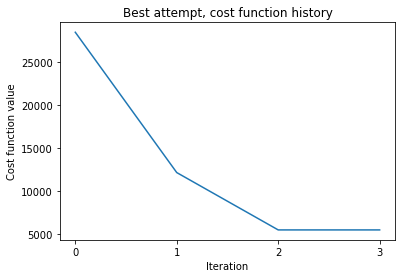

In [15]:
plt.title("Best attempt, cost function history")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
xticks_list = range(0, n_iter, 1)
plt.xticks(xticks_list)
plt.plot(cost_value_history)

In [16]:
paleta = col.LinearSegmentedColormap.from_list(
        'my_colors', ['#ff0000', '#00ff00', '#0000ff'])

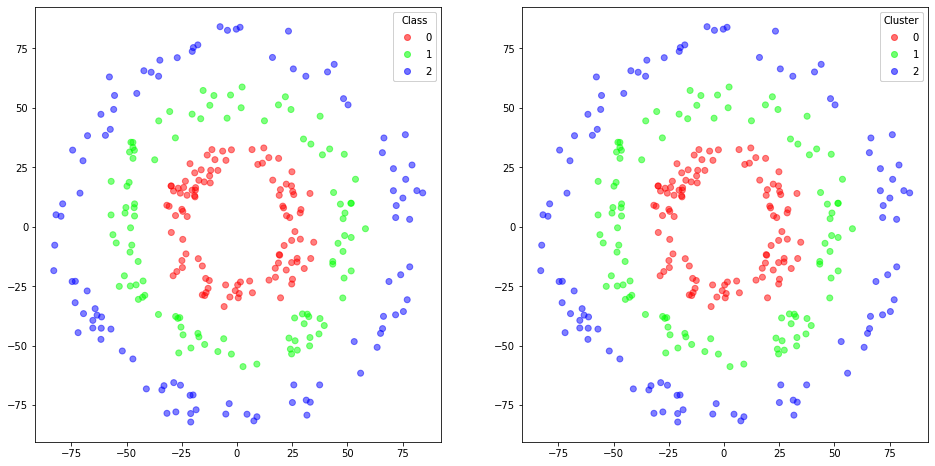

In [17]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
plt.subplot(1, 2, 1)
scatter = ax[0].scatter(x=X[:,0], y=X[:,1], c=y, alpha=0.5, cmap=paleta)
my_legend = ax[0].legend(*scatter.legend_elements(), loc="upper right", title="Class")
ax[0].add_artist(my_legend)
plt.subplot(1, 2, 2)
scatter = ax[1].scatter(x=X[:,0], y=X[:,1], c=best_cluster_labels, alpha=0.5, cmap=paleta)
my_legend = ax[1].legend(*scatter.legend_elements(), loc="upper right", title="Cluster")
ax[1].add_artist(my_legend)

It seems that we have a perfect clustering. 
The contingency table will tell us more details

In [18]:
best_contingency_matrix = contingency_matrix(labels_true=y, labels_pred=best_cluster_labels)
best_contingency_matrix

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

In [19]:
def pretty_print_cm(cm: np.ndarray, true_classes: list):
    line = '          '
    for j in range(0, cm.shape[1]):
        line = line + (' Cluster {:2}'.format(j))
    print(line)
    for i, row in enumerate(cm):
        line = 'Class {:2}: '.format(int(true_classes[i])) + ''.join(''.join(['{:11}'.format(element) for element in row]))
        print(line)

In [20]:
pretty_print_cm(cm=best_contingency_matrix, true_classes=y_classes)

           Cluster  0 Cluster  1 Cluster  2
Class  0:         100          0          0
Class  1:           0        100          0
Class  2:           0          0        100


It seems that there are not misclassified samples... hip, hip, hurra!

In [21]:
best_v_measure = v_measure_score(labels_true=y, labels_pred=best_cluster_labels)
best_v_measure

1.0

### Conclusions

Bla, bla, ...